# Project: Book Rating Prediction Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## 1. Load dataset

In [2]:
# raise a warning when a bad line (a line with too many fields) is encountered and skip that line
df = pd.read_csv("books.csv", on_bad_lines='warn')

C:\Users\HP\AppData\Local\Temp\ipykernel_15952\79441328.py:2: ParserWarning: Skipping line 3350: expected 12 fields, saw 13
Skipping line 4704: expected 12 fields, saw 13
Skipping line 5879: expected 12 fields, saw 13
Skipping line 8981: expected 12 fields, saw 13

  df = pd.read_csv("books.csv", on_bad_lines='warn')


In [3]:
df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


## 2. Dataset analysis

In [4]:
df.describe()

,bookID,average_rating,isbn13,num_pages,ratings_count,text_reviews_count
count,11123.000000,11123.000000,1.112300e+04,11123.000000,1.112300e+04,11123.000000
mean,21310.856963,3.934075,9.759880e+12,336.405556,1.794285e+04,542.048099
std,13094.727252,0.350485,4.429758e+11,241.152626,1.124992e+05,2576.619589
min,1.000000,0.000000,8.987060e+09,0.000000,0.000000e+00,0.000000
25%,10277.500000,3.770000,9.780345e+12,192.000000,1.040000e+02,9.000000
50%,20287.000000,3.960000,9.780582e+12,299.000000,7.450000e+02,47.000000
75%,32104.500000,4.140000,9.780872e+12,416.000000,5.000500e+03,238.000000
max,45641.000000,5.000000,9.790008e+12,6576.000000,4.597666e+06,94265.000000


#### Data distribution

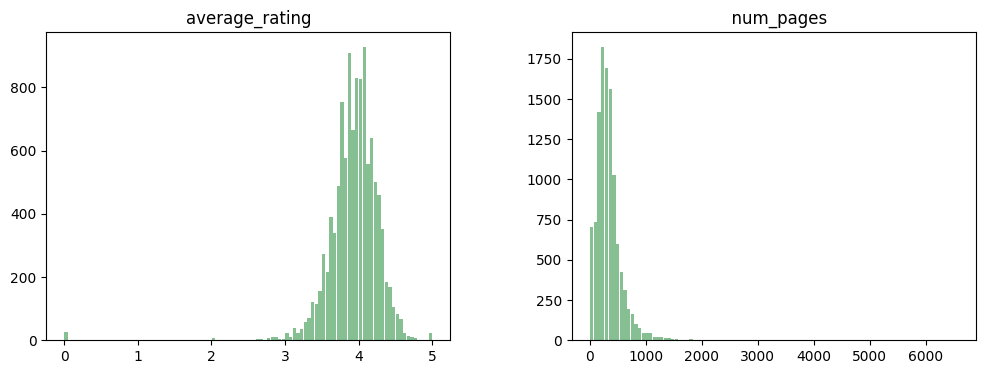

In [5]:
df.hist(column=["average_rating", "  num_pages"], 
        bins=100, grid=False, figsize=(12,4), color='#86bf91', rwidth=0.9)
plt.show()

#### Plotting each dimension against the target

In [6]:
df[["  num_pages", "average_rating", "ratings_count"]].corr()

,num_pages,average_rating,ratings_count
num_pages,1.000000,0.150477,0.034337
average_rating,0.150477,1.000000,0.038224
ratings_count,0.034337,0.038224,1.000000


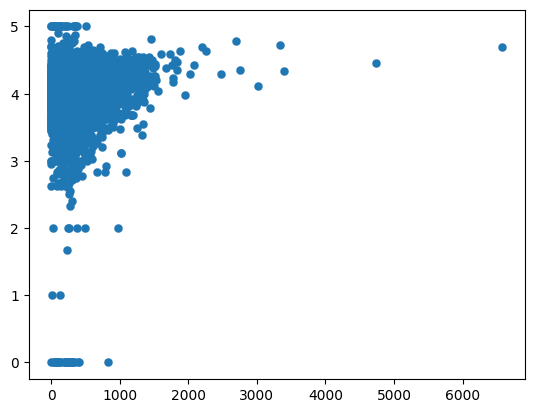

In [7]:
plt.scatter(df["  num_pages"], df["average_rating"], linewidths=0.1)

In [8]:
(df['average_rating'] < 1).sum()

25

C:\Users\HP\AppData\Local\Temp\ipykernel_15952\996516365.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, language_counts[i], str(language_counts[i]), ha='center', va='bottom')


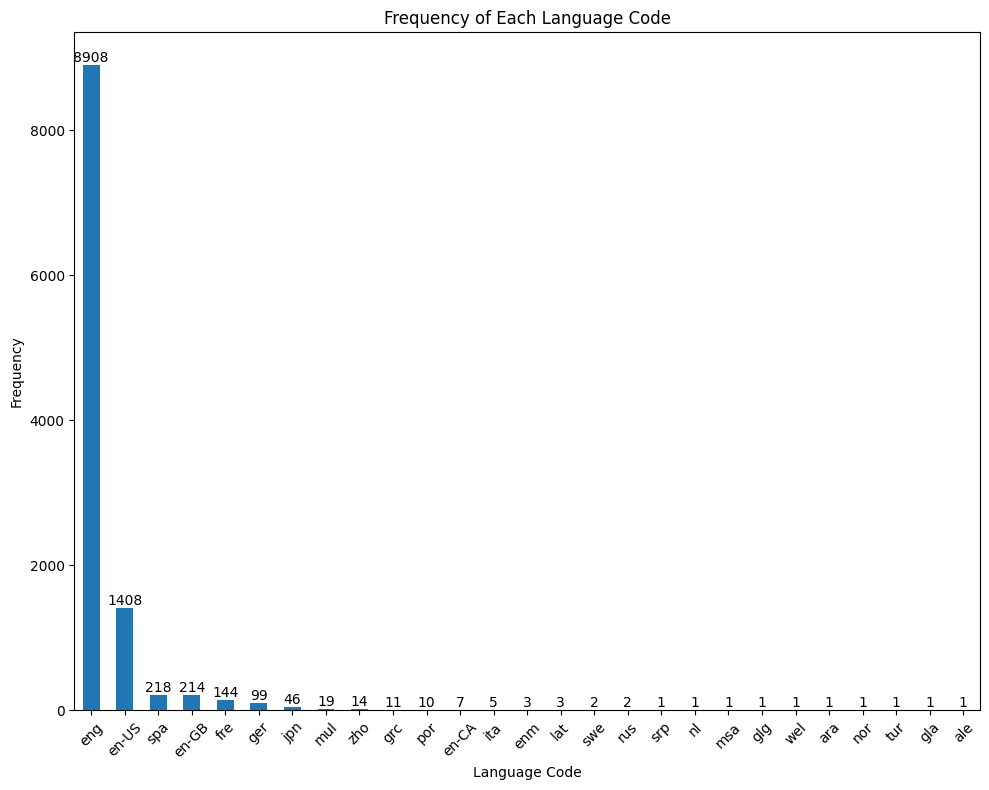

In [9]:
# Counting the frequency of each language code
language_counts = df['language_code'].value_counts()

# Creating a bar chart for the language codes
plt.figure(figsize=(10, 8))
language_counts.plot(kind='bar')
plt.title('Frequency of Each Language Code')
plt.xlabel('Language Code')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

for i in range(len(language_counts)):
    plt.text(i, language_counts[i], str(language_counts[i]), ha='center', va='bottom')
    
plt.tight_layout()

## 3 Pre-Processing

#### Removing irrelevant feature

In [10]:
df = df.drop(['bookID', 'title', 'isbn', 'isbn13'], axis = 1)

#### Exclude languages with fewer than 99 books from the dataset

In [11]:
df['language_code'].replace({'en-US':'eng', 'en-GB':'eng', 'en-CA':'eng'}, inplace=True)
language_counts = df['language_code'].value_counts()
df = df[~df['language_code'].isin(language_counts[language_counts < 99].index)]

C:\Users\HP\AppData\Local\Temp\ipykernel_15952\3057680666.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['language_code'].replace({'en-US':'eng', 'en-GB':'eng', 'en-CA':'eng'}, inplace=True)


In [12]:
df['language_code'].value_counts()

language_code
eng    10537
spa      218
fre      144
ger       99
Name: count, dtype: int64

#### Removing unnecessary spaces

In [13]:
df.rename(columns=lambda x: x.strip(), inplace=True)

#### Filter out books that have received too few ratings

In [14]:
df.query("ratings_count >= 20", inplace=True)

In [15]:
df.describe()

,average_rating,num_pages,ratings_count,text_reviews_count
count,9941.000000,9941.000000,9.941000e+03,9941.000000
mean,3.947065,343.476612,2.006989e+04,606.212956
std,0.271735,240.175589,1.188209e+05,2718.392407
min,2.400000,0.000000,2.000000e+01,0.000000
25%,3.780000,206.000000,2.080000e+02,16.000000
50%,3.960000,304.000000,1.101000e+03,65.000000
75%,4.130000,419.000000,6.253000e+03,293.000000
max,4.820000,6576.000000,4.597666e+06,94265.000000


In [16]:
def preprocess_author_name(author_name):
    # Remove spaces in the author's name and delete characters before the '/'
    return author_name.replace(" ", "").split("/")[0]

df['authors'] = df['authors'].apply(lambda x: preprocess_author_name(x))

In [17]:
df.nunique()

authors               3732
average_rating         191
language_code            4
num_pages              979
ratings_count         5269
text_reviews_count    1822
publication_date      3381
publisher             1919
dtype: int64

#### Date encoding

In [18]:
df['publication_date'] = pd.to_datetime(df['publication_date'], format='%m/%d/%Y', errors='coerce')

In [19]:
print(len(df[df['publication_date'].isnull()]))

1


In [20]:
df.dropna(subset=['publication_date'], inplace=True)
df['publication_date'] = df['publication_date'].apply(lambda x: x.timestamp())

In [21]:
def binary_encoder(df, column_name):
    encoder = preprocessing.OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded = encoder.fit_transform(df[[column_name]])
    encoded_column_name = encoder.get_feature_names_out([column_name])
    encoded_df = pd.DataFrame(encoded, columns=encoded_column_name)
    df = pd.concat([df.reset_index(drop=True), encoded_df], axis=1)
    df.drop(column_name, axis=1, inplace=True)
    return df

In [22]:
# df = binary_encoder(df, 'publisher')
df = binary_encoder(df, 'authors')
df = binary_encoder(df, 'language_code')
df.head()

,average_rating,num_pages,ratings_count,text_reviews_count,publication_date,publisher,authors_A.B.Yehoshua,authors_A.J.Jacobs,authors_A.M.Homes,authors_A.N.Roquelaure,...,authors_ZoraNealeHurston,authors_ZoëHeller,authors_bellhooks,authors_ÅsneSeierstad,authors_ÉmileZola,authors_Éric-EmmanuelSchmitt,language_code_eng,language_code_fre,language_code_ger,language_code_spa
0,4.57,652,2095690,27591,1.158365e+09,Scholastic Inc.,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,4.49,870,2153167,29221,1.093997e+09,Scholastic Inc.,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,4.42,352,6333,244,1.067645e+09,Scholastic,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,4.56,435,2339585,36325,1.083370e+09,Scholastic Inc.,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4.78,2690,41428,164,1.095034e+09,Scholastic,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


#### Cleaned dataset

In [23]:
df.to_csv('books_cleaned.csv', index=False)

## Linear regression
#### I choose this model as it is a simple and interpretable model that assumes a linear relationship between the input features and the target variable. 

In [24]:
X = df.drop(['average_rating', 'publisher'], axis = 1)
y = df['average_rating']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
linReg = LinearRegression()
linReg.fit(X_train, y_train)

LinearRegression()

In [25]:
y_pred = linReg.predict(X_test)

In [26]:
print('Mean Absolute Error (MAE):', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error (MSE):', mean_squared_error(y_test, y_pred))
print("Coefficient de détermination (R-squared) :", r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 0.16654931843299806
Mean Squared Error (MSE): 0.05098991513095391
Coefficient de détermination (R-squared) : 0.2557792234593762


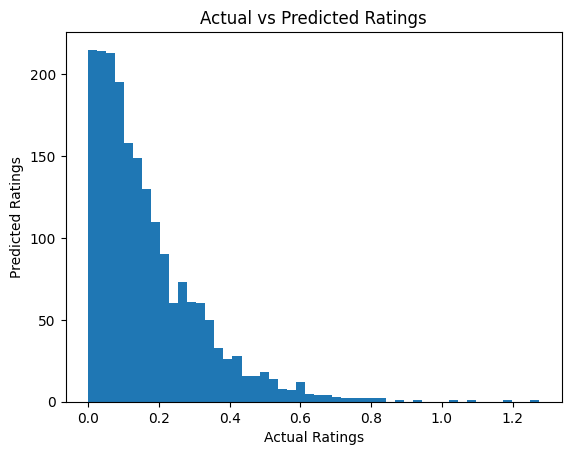

In [33]:
err_hist = np.abs(y_test-y_pred)
plt.hist(err_hist, bins=50)
plt.title('Actual vs Predicted Ratings')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.show()

## Random Forest Regression
#### I choose Random forest regression as it provides a measure of feature importance, which can help identify the most relevant features for predicting the target variable.

In [28]:
from sklearn.ensemble import RandomForestRegressor
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialiser et entraîner le modèle
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
predictions = model.predict(X_test)

# Évaluer le modèle
print('Mean Absolute Error (MAE):', mean_absolute_error(y_test, predictions))
print('Mean Squared Error (MSE):', mean_squared_error(y_test, predictions))
print("Coefficient de détermination (R-squared) :", r2_score(y_test, predictions))


Mean Absolute Error (MAE): 0.18966272635814888
Mean Squared Error (MSE): 0.06138109187625757
Coefficient de détermination (R-squared) : 0.2099334577776537


Model Performance: Absolute Error Distribution

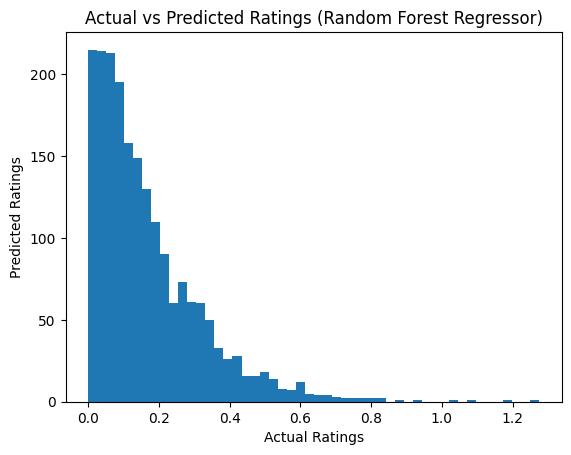

In [34]:
err_hist = np.abs(y_test-y_pred)
plt.hist(err_hist, bins=50)
plt.title('Actual vs Predicted Ratings (Random Forest Regressor)')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.show()

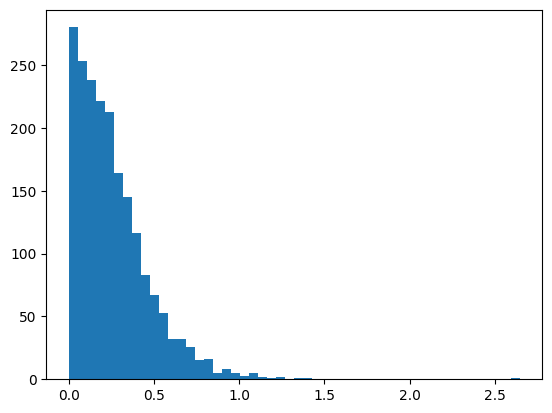

In [30]:
err_hist = np.abs(y_test-y_pred)
plt.hist(err_hist, bins=50)
plt.show()

#### Feature Engineering

##### Training the  linear regression using the engineered feature (avg_rating_publisher)

#### The choice of linear regression and random forest regression, along with training using the engineered feature avg_rating_publisher, is motivated by considerations of model simplicity, non-linearity, robustness, interpretability, domain knowledge, and potential predictive power. These choices aim to build effective regression models for predicting book ratings based on the provided dataset.

In [43]:
# Calculate average rating for each publisher
publisher_avg_rating = df.groupby('publisher')['average_rating'].mean().reset_index()
publisher_avg_rating.columns = ['publisher', 'avg_rating_by_publisher']

# Merge the average ratings with the original dataset based on the publisher column
df = pd.merge(df, publisher_avg_rating, on='publisher', how='left')


In [42]:
##Training the linear regression using the engineered feature (avg_rating_by_publisher)

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Separate features (X) and target variable (y)
X = df[['avg_rating_by_publisher']]  # Selecting only the new feature
y = df['average_rating']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Initialize and train the Linear Regression model
linReg = LinearRegression()
linReg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = linReg.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Squared Error (MSE):', mse)
print("Coefficient de détermination (R-squared) :", r2)



Mean Absolute Error (MAE): 0.1793117807501641
Mean Squared Error (MSE): 0.08176690329713568
Coefficient de détermination (R-squared) : 0.4949822450089928


##### Training Random Regression with New feature avg_rating_by_publisher 

In [41]:
# Training Random Regression with New feature avg_rating_by_publisher 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Separate features (X) and target variable (y)
X = df[['avg_rating_by_publisher']]  # Selecting only the new feature
y = df['average_rating']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Initialize and train the Random Forest Regression model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = rf_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Squared Error (MSE):', mse)
print("Coefficient de détermination (R-squared) :", r2)


Mean Absolute Error (MAE): 0.19860316372671574
Mean Squared Error (MSE): 0.0981804310552625
Coefficient de détermination (R-squared) : 0.2067466426758493


In [ ]:
import matplotlib.pyplot as plt

# Scatter plot of actual vs. predicted ratings
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs. Predicted Ratings')
plt.show()

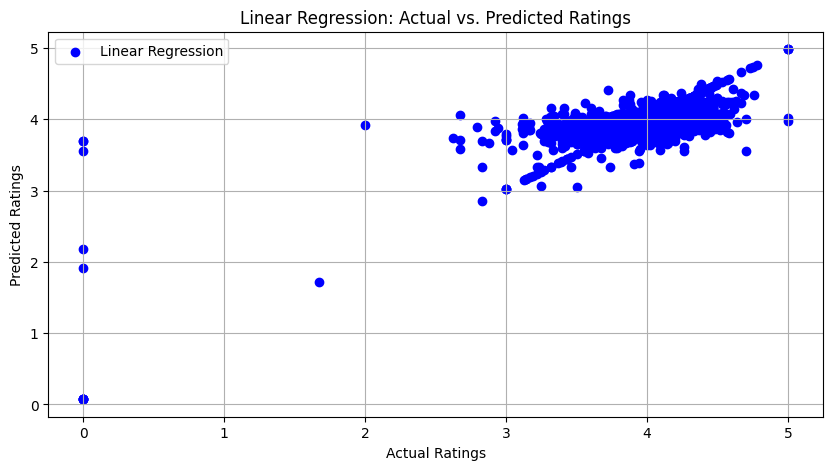

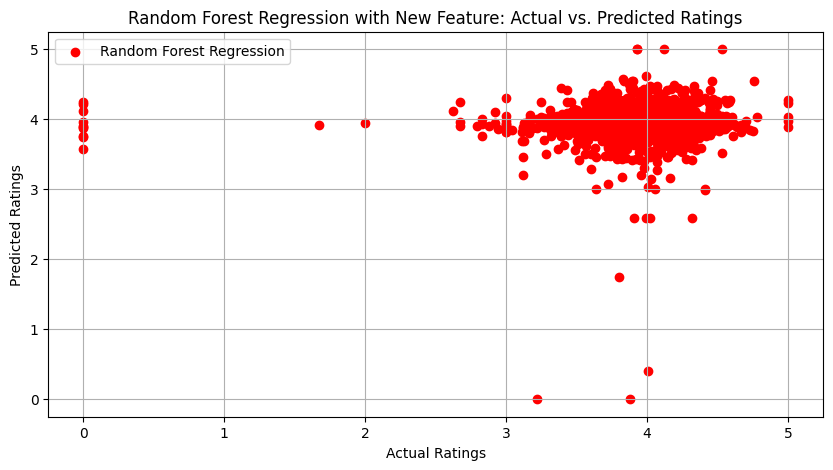

In [44]:
#Visualizisation

import matplotlib.pyplot as plt

# Scatter plot for Linear Regression model
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, color='blue', label='Linear Regression')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Linear Regression: Actual vs. Predicted Ratings')
plt.legend()
plt.grid(True)
plt.show()

# Scatter plot for Random Forest Regression model
plt.figure(figsize=(10, 5))
plt.scatter(y_test, predictions, color='red', label='Random Forest Regression')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Random Forest Regression with New Feature: Actual vs. Predicted Ratings')
plt.legend()
plt.grid(True)
plt.show()


Conclusion:

The Linear Regression model has a lower Mean Absolute Error (MAE) and Mean Squared Error (MSE) compared to the Random Forest Regression model with the new feature avg_rating_by_publisher. This indicates that, on average, the predictions made by the Linear Regression model are closer to the actual ratings.
Additionally, the Linear Regression model has a higher R-squared score compared to the Random Forest Regression model with the new feature. This indicates that a larger proportion of the variance in the ratings can be explained by the features in the Linear Regression model.
Therefore, based on these evaluation metrics, the Linear Regression model appears to outperform the Random Forest Regression model with the new feature avg_rating_by_publisher for predicting book ratings in this scenario.


#### Neural network

In [48]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Data preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#
# Determine the number of features in your dataset
num_features = X_scaled.shape[1]

# Define the neural network model with the same number of hidden layers as MLPRegressor
model_nn = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(num_features,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
# Compile the model
model_nn.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model_nn.fit(X_scaled, y_train, epochs=30, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
y_pred_nn = model_nn.predict(X_test_scaled)
mae_nn = mean_absolute_error(y_test, y_pred_nn)
print('Mean Absolute Error (MAE) for Neural Network:', mae_nn)


Epoch 1/30
223/223 [==============================] - 3s 5ms/step - loss: 2.9197 - val_loss: 0.0767
Epoch 2/30
223/223 [==============================] - 1s 4ms/step - loss: 0.0704 - val_loss: 0.0556
Epoch 3/30
223/223 [==============================] - 1s 4ms/step - loss: 0.0665 - val_loss: 0.0608
Epoch 4/30
223/223 [==============================] - 1s 4ms/step - loss: 0.0668 - val_loss: 0.0583
Epoch 5/30
223/223 [==============================] - 1s 4ms/step - loss: 0.0669 - val_loss: 0.0591
Epoch 6/30
223/223 [==============================] - 1s 5ms/step - loss: 0.0658 - val_loss: 0.0605
Epoch 7/30
223/223 [==============================] - 1s 4ms/step - loss: 0.0684 - val_loss: 0.0606
Epoch 8/30
223/223 [==============================] - 1s 4ms/step - loss: 0.0670 - val_loss: 0.0549
Epoch 9/30
223/223 [==============================] - 1s 5ms/step - loss: 0.0663 - val_loss: 0.0554
Epoch 10/30
223/223 [==============================] - 1s 3ms/step - loss: 0.0694 - val_loss: 0.0577

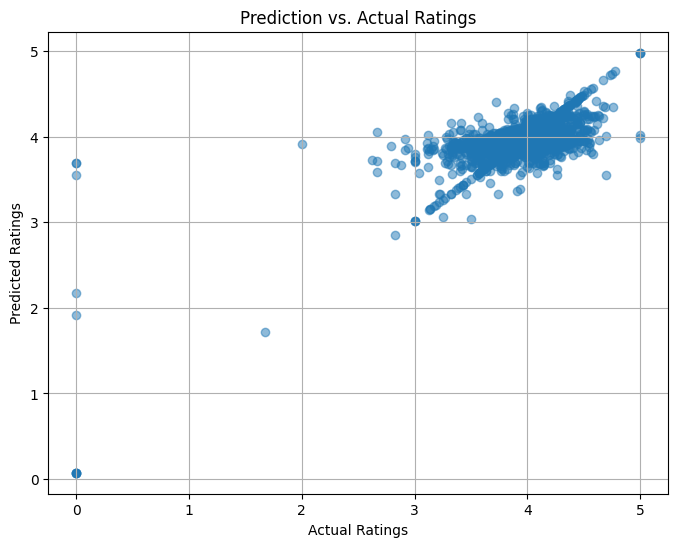

In [51]:
import matplotlib.pyplot as plt

# Plotting Prediction vs. Actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Prediction vs. Actual Ratings')
plt.grid(True)
plt.show()
